Link: https://towardsdatascience.com/ab-testing-with-python-e5964dd66143

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Teste Bicaudal

Nível de confiança = 95%.

alpha = 0.05

Tamanho da amostra: 0.13, 0.15

In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

In [ ]:
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

print(required_n)

4719.4740575998185


In [ ]:
required_n = ceil(required_n)
print(required_n)

4720


In [ ]:
df = pd.read_csv("/content/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.shape

(294478, 5)

In [ ]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.converted.sum()

35237

In [ ]:
df.landing_page.value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [ ]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users)

3894


In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
df.shape

(286690, 5)

In [ ]:
sample = df.sample(required_n)
sample.shape

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=123)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=123)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,689587,2017-01-13 11:17:53.637947,control,old_page,0
1,708802,2017-01-17 06:26:13.317907,control,old_page,0
2,734166,2017-01-09 03:16:50.487997,control,old_page,0
3,679205,2017-01-21 08:14:08.970343,control,old_page,0
4,664151,2017-01-10 09:55:59.891293,control,old_page,0


In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [ ]:
ab_test.group.value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.119068,0.323868,0.004714
treatment,0.119703,0.324614,0.004725


In [ ]:
sns.set_style('darkgrid')

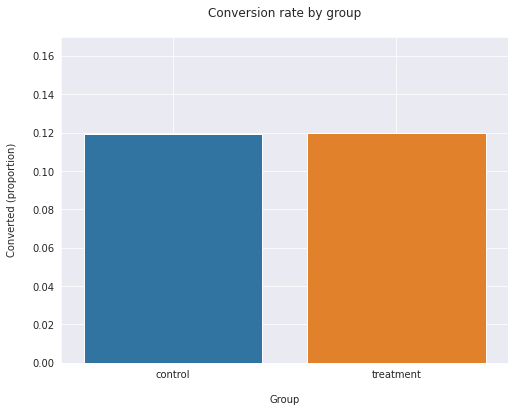

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.grid(True)
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']

treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.5)

In [ ]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.10
p-value: 0.924
ci 95% for control group: [0.116, 0.122]
ci 95% for treatment group: [0.117, 0.123]


Como o p-value é maior que 0.05 (ideial), não podemos rejeitar a hipótese nula, ou seja, o novo design não teve um desempenho melhor que o antigo.